In [78]:
import json
import os
import sys
import argparse
from glob import glob

import torch

from pathlib import Path
import pandas as pd
import numpy as np
from tqdm import tqdm
from datetime import datetime
import shared.utils as su

### Load data

In [2]:
def load_jsonl_data(file_path):
    """Load JSONL data from file"""
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            data.append(json.loads(line.strip()))
    return data


data_dir = "/scratch/shared/beegfs/piyush/datasets/CameraBench"
jsonl_file = f"{data_dir}/t2v_metrics/camerabench/data/binary_classification/Move_Down.jsonl"
assert os.path.exists(jsonl_file)
data = load_jsonl_data(jsonl_file)
len(data), data[0]

(430,
 {'image': 'u35WIs62R2M.1.4.mp4',
  'question': 'Does the camera move downward (not tilting down) with respect to the initial frame?',
  'label': 'Yes',
  'task': 'Move Down',
  'label_name': 'cam_motion.camera_centric_movement.downward.has_downward_wrt_camera'})

### Load model

In [3]:
# Load model
from models.modeling_encoders import AutoEncoder

# model_id = "/work/piyush/experiments/CaRe/Tarsier-7b/nli-9k+ego4d-1k/merged_checkpoint"
model_id = "/work/piyush/experiments/CaRe/Tarsier-7b/final-10112025/"\
    "nli_9000+ego_1000+subj_replaced-seed_42/merged_checkpoint"
encoder = AutoEncoder.from_pretrained(model_id, device_map='auto')
su.misc.num_params(encoder.model)

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


Loading EncoderForTarsier from /work/piyush/experiments/CaRe/Tarsier-7b/final-10112025/nli_9000+ego_1000+subj_replaced-seed_42/merged_checkpoint
### do_image_padding is set as False, images will be resized directly!


The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.
TarsierForConditionalGeneration has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
You are attempting to use Flash Attention 2.

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

::: Number of total parameters in TarsierForConditionalGeneration: 7063.427M


**Compute embeddings for all videos**

In [4]:
from utils.video import read_frames_decord

In [8]:
video_paths = sorted(glob(f"{data_dir}/videos/*"))
print("Number of videos: ", len(video_paths))

iterator = su.log.tqdm_iterator(range(len(video_paths)), desc='Computing video embddings')
video_feat = {}
for i in iterator:
    p = video_paths[i]

    try:
        pixel_values = read_frames_decord(p, num_frames=16)
        with torch.no_grad():
            zv = encoder.encode_vision(pixel_values.unsqueeze(0))
            zv = torch.nn.functional.normalize(zv, dim=-1).squeeze(0).cpu().float()
        video_feat[os.path.basename(p).split(".mp4")[0]] = zv
    except:
        print(f"Failed {p}.")
        continue

len(video_feat)

Number of videos:  1071


Computing video embddings:   0%|          | 0/1071 [00:00<?, ?it/s]

1071

In [44]:
df['video_id'] = df.image.apply(lambda x: x.split(".mp4")[0])
video_id_to_sent_pos = dict(zip(df['video_id'], df['sent_pos']))
len(video_id_to_sent_pos)

969

In [56]:
len(df['sent_pos'].unique())

15

In [48]:
labels = [video_id_to_sent_pos.get(k, 'na') for k in video_feat]
np.unique(labels), len(labels)

(array(['The camera is completely still without any motion or shaking',
        'The camera moves backward (not zooming out) with respect to the initial frame',
        'The camera moves downward (not tilting down) with respect to the initial frame',
        'The camera moves rightward in the scene',
        'The camera pans to the left', 'The camera pans to the right',
        'The camera tilts upward', 'The camera zooms in',
        'The camera zooms out', 'na'], dtype='<U78'),
 1071)

Number of unique labels: 10


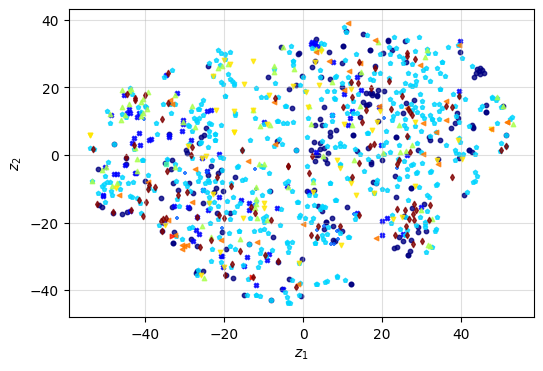

In [55]:
ZV = torch.stack([v for k, v in video_feat.items()])
su.visualize.show_projections_with_labels(ZV, labels=labels, legend_outside=True, legend_ncol=1, cmap='jet', legend=False)

**Compute text embeddings**

In [26]:
def question_to_statements(question):
    """
    Convert a camera motion question into affirmative and negative statements.
    
    Args:
        question (str): A yes/no question about camera motion
        
    Returns:
        tuple: (affirmative_statement, negative_statement)
    """
    
    # Hardcoded mapping of questions to (positive, negative) statement pairs
    question_map = {
        'Does the camera move upward (not tilting up) with respect to the initial frame?': (
            'The camera moves upward (not tilting up) with respect to the initial frame',
            'The camera moves downward (not tilting down) with respect to the initial frame'
        ),
        'Does the camera tilt downward?': (
            'The camera tilts downward',
            'The camera tilts upward'
        ),
        'Does the camera roll clockwise?': (
            'The camera rolls clockwise',
            'The camera rolls counterclockwise'
        ),
        'Does the camera move forward (not zooming in) with respect to the initial frame?': (
            'The camera moves forward (not zooming in) with respect to the initial frame',
            'The camera moves backward (not zooming out) with respect to the initial frame'
        ),
        'Does the camera move leftward in the scene?': (
            'The camera moves leftward in the scene',
            'The camera moves rightward in the scene'
        ),
        'Does the camera roll counterclockwise?': (
            'The camera rolls counterclockwise',
            'The camera rolls clockwise'
        ),
        'Is the camera completely still without any motion or shaking?': (
            'The camera is completely still without any motion or shaking',
            'The camera is moving'
        ),
        'Does the camera zoom out?': (
            'The camera zooms out',
            'The camera zooms in'
        ),
        'Does the camera move backward (not zooming out) with respect to the initial frame?': (
            'The camera moves backward (not zooming out) with respect to the initial frame',
            'The camera moves forward (not zooming in) with respect to the initial frame'
        ),
        'Does the camera pan to the left?': (
            'The camera pans to the left',
            'The camera pans to the right'
        ),
        'Does the camera move downward (not tilting down) with respect to the initial frame?': (
            'The camera moves downward (not tilting down) with respect to the initial frame',
            'The camera moves upward (not tilting up) with respect to the initial frame'
        ),
        'Does the camera zoom in?': (
            'The camera zooms in',
            'The camera zooms out'
        ),
        'Does the camera pan to the right?': (
            'The camera pans to the right',
            'The camera pans to the left'
        ),
        'Does the camera tilt upward?': (
            'The camera tilts upward',
            'The camera tilts downward'
        ),
        'Does the camera move rightward in the scene?': (
            'The camera moves rightward in the scene',
            'The camera moves leftward in the scene'
        )
    }
    
    # Return the mapped statements, or a fallback if question not found
    if question in question_map:
        return question_map[question]
    else:
        return (f"Unknown question: {question}", f"Unknown question: {question}")


# Test with the provided examples
if __name__ == "__main__":
    questions = [
        'Does the camera move upward (not tilting up) with respect to the initial frame?',
        'Does the camera tilt downward?',
        'Does the camera roll clockwise?',
        'Does the camera move forward (not zooming in) with respect to the initial frame?',
        'Does the camera move leftward in the scene?',
        'Does the camera roll counterclockwise?',
        'Is the camera completely still without any motion or shaking?',
        'Does the camera zoom out?',
        'Does the camera move backward (not zooming out) with respect to the initial frame?',
        'Does the camera pan to the left?',
        'Does the camera move downward (not tilting down) with respect to the initial frame?',
        'Does the camera zoom in?',
        'Does the camera pan to the right?',
        'Does the camera tilt upward?',
        'Does the camera move rightward in the scene?'
    ]
    
    for question in questions:
        affirmative, negative = question_to_statements(question)
        print(f"Q: {question}")
        print(f"A: {affirmative}")
        print(f"B: {negative}")
        print()

Q: Does the camera move upward (not tilting up) with respect to the initial frame?
A: The camera moves upward (not tilting up) with respect to the initial frame
B: The camera moves downward (not tilting down) with respect to the initial frame

Q: Does the camera tilt downward?
A: The camera tilts downward
B: The camera tilts upward

Q: Does the camera roll clockwise?
A: The camera rolls clockwise
B: The camera rolls counterclockwise

Q: Does the camera move forward (not zooming in) with respect to the initial frame?
A: The camera moves forward (not zooming in) with respect to the initial frame
B: The camera moves backward (not zooming out) with respect to the initial frame

Q: Does the camera move leftward in the scene?
A: The camera moves leftward in the scene
B: The camera moves rightward in the scene

Q: Does the camera roll counterclockwise?
A: The camera rolls counterclockwise
B: The camera rolls clockwise

Q: Is the camera completely still without any motion or shaking?
A: The ca

In [31]:
files = glob(f"{data_dir}/t2v_metrics/camerabench/data/binary_classification/*")
df = []
questions = []
for f in files:
    data = su.io.load_jsonl(f)
    data = pd.DataFrame(data)
    data['task'] = os.path.basename(f).split('.jsonl')[0]

    question = data.question.unique()[0]
    sent_pos, sent_neg = question_to_statements(question)
    data['sent_pos'] = sent_pos
    data['sent_neg'] = sent_neg
    df.append(data)
df = pd.concat(df).drop_duplicates()
    
    # _questions = data.question.unique()
    # questions.append(_questions)
# questions = np.concatenate(questions)
# questions.shape
df.shape

(7679, 7)

In [34]:
# Compute embeddings for all unique sentences
sentences = list(df['sent_pos'].unique()) + list(df['sent_neg'].unique())
len(sentences)

30

In [37]:
text_feat = {}
for s in su.log.tqdm_iterator(sentences, desc='Computing text embeddings'):
    with torch.no_grad():
        zt = encoder.encode_text(s)
        zt = torch.nn.functional.normalize(zt, dim=-1).squeeze(0).cpu().float()
    text_feat[s] = zt
len(text_feat)

Computing text embeddings:   0%|          | 0/30 [00:00<?, ?it/s]

16

**Analyze static understanding**

In [84]:
subdf = df[df.task == 'Static']
subdf.shape, subdf.iloc[0]

((966, 8),
 image                                             5454.1.13.mp4
 question      Is the camera completely still without any mot...
 label                                                       Yes
 task                                                     Static
 label_name      cam_motion.steadiness_and_movement.fixed_camera
 sent_pos      The camera is completely still without any mot...
 sent_neg                                   The camera is moving
 video_id                                              5454.1.13
 Name: 0, dtype: object)

In [97]:
subdf.label.value_counts()

label
No     872
Yes     94
Name: count, dtype: int64

In [87]:
sent_pos = "The camera is static"
sent_neg = "The camera is not static"
with torch.no_grad():
    zt_pos = encoder.encode_text(sent_pos)
    zt_pos = torch.nn.functional.normalize(zt_pos, dim=-1).cpu().squeeze().float()
    zt_neg = encoder.encode_text(sent_neg)
    zt_neg = torch.nn.functional.normalize(zt_neg, dim=-1).cpu().squeeze().float()
zt_pos, zt_neg

(tensor([-0.0171, -0.0089,  0.0095,  ...,  0.0045, -0.0040, -0.0312]),
 tensor([-0.0064,  0.0103,  0.0178,  ..., -0.0089,  0.0114, -0.0128]))

In [98]:
correct = []
for i in range(len(subdf)):
    row = subdf.iloc[i]
    zv = video_feat[row.video_id]
    sim_pos = zv @ zt_pos.T
    sim_neg = zv @ zt_neg.T

    if row.label == "Yes":
        correct.append(sim_pos > sim_neg)
    else:
        correct.append(sim_neg > sim_pos)

correct = torch.tensor(correct)
correct.float().mean()

tensor(0.8395)

**Visualize**

Number of unique labels: 2


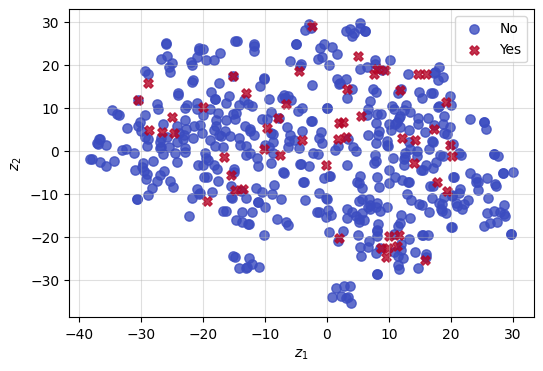

In [131]:
_df = df[df.task == 'Move_Out']
su.visualize.show_projections_with_labels(
    torch.stack([video_feat[k] for k in _df.video_id]),
    labels=_df.label.tolist(),
    legend_outside=False, legend_ncol=1, cmap='coolwarm', legend=True, method='tsne', s=45
)

In [139]:
import numpy as np
import matplotlib.pyplot as plt

def plot_smooth_dists(a, b, bins=100, sigma=1.5, c1='red', c2='blue'):
    a, b = np.asarray(a), np.asarray(b)
    lo = min(a.min(), b.min())
    hi = max(a.max(), b.max())
    rng = (lo, hi)

    def smooth(x):
        h, e = np.histogram(x, bins=bins, range=rng, density=True)
        k = np.exp(-0.5 * (np.linspace(-3, 3, 51) / sigma) ** 2)
        k /= k.sum()
        s = np.convolve(h, k, mode='same')
        c = 0.5 * (e[:-1] + e[1:])
        return c, s

    cA, sA = smooth(a)
    cB, sB = smooth(b)

    plt.plot(cA, sA, color=c1)
    plt.fill_between(cA, sA, color=c1, alpha=0.2)
    plt.plot(cB, sB, color=c2)
    plt.fill_between(cB, sB, color=c2, alpha=0.2)


Tilt_Down


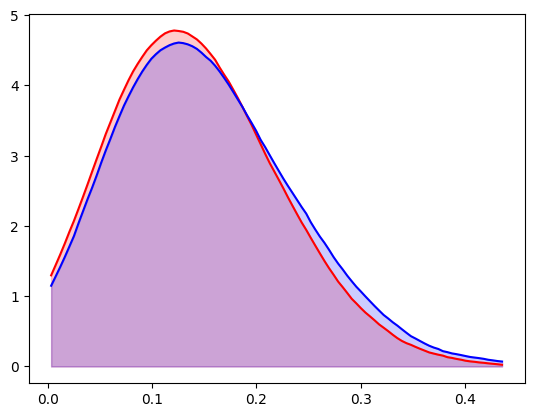

In [160]:
import matplotlib.pyplot as plt

correct = []
sims_pos = []
sims_neg = []
task = np.random.choice(df.task.unique())
print(task)

subdf = df[df.task == task]
for i in range(len(subdf)):
    row = subdf.iloc[i]
    zv = video_feat[row.video_id]

    sent_pos, sent_neg = question_to_statements(row['question'])
    zt_pos = text_feat[sent_pos]
    zt_neg = text_feat[sent_neg]
    
    sim_pos = zv @ zt_pos.T
    sim_neg = zv @ zt_neg.T
    if row['label'] == 'Yes':
        correct.append(sim_pos > sim_neg)
    else:
        correct.append(sim_pos < sim_neg)
    sims_pos.append(sim_pos)
    sims_neg.append(sim_neg)

# plt.hist(sims_pos, bins=100);
# plt.hist(sims_neg, bins=100);

plot_smooth_dists(sims_pos, sims_neg)
plt.show()

In [166]:
row

image                                       MuNyfqxAO6Y.2.4.mp4
question           Does the camera move rightward in the scene?
label                                                        No
task                                                 Move_Right
label_name    cam_motion.camera_centric_movement.rightward.h...
sent_pos                The camera moves rightward in the scene
sent_neg                 The camera moves leftward in the scene
video_id                                        MuNyfqxAO6Y.2.4
Name: 486, dtype: object

In [172]:
from sklearn.metrics import average_precision_score
avg_ap = []
for task in df.task.unique():
    # print("Task: ", task)
    labels = []
    subdf = df[df.task == task]
    scores = []
    for i in range(len(subdf)):
        row = subdf.iloc[i]
        zv = video_feat[row.video_id]
    
        sent_pos, sent_neg = question_to_statements(row['question'])
        zt_pos = text_feat[sent_pos]
        zt_neg = text_feat[sent_neg]
        
        sim_pos = zv @ zt_pos.T
        sim_neg = zv @ zt_neg.T
        score = torch.nn.functional.softmax(torch.tensor([sim_pos, sim_neg]))[0]
        # score = sim_pos
        scores.append(score)
        labels.append(int(row['label'] == 'Yes'))
    scores = torch.tensor(scores)
    ap = average_precision_score(y_true=labels, y_score=scores.numpy())
    ap = np.round(ap * 100., 2)
    avg_ap.append(ap)
    print(f"{task}: {ap}")
print("Avg. AP: ", np.mean(avg_ap))

Move_Up: 10.54
Tilt_Down: 12.5
Roll_Clockwise: 13.81
Move_In: 66.47
Move_Left: 9.2
Roll_Counterclockwise: 10.27
Static: 18.61
Zoom_Out: 19.04
Move_Out: 10.97
Pan_Left: 14.89
Move_Down: 11.37
Zoom_In: 19.3
Pan_Right: 20.14
Tilt_Up: 38.52
Move_Right: 17.96
Avg. AP:  19.572666666666667


**Compute metrics**

In [99]:
df.task.unique()

array(['Move_Up', 'Tilt_Down', 'Roll_Clockwise', 'Move_In', 'Move_Left',
       'Roll_Counterclockwise', 'Static', 'Zoom_Out', 'Move_Out',
       'Pan_Left', 'Move_Down', 'Zoom_In', 'Pan_Right', 'Tilt_Up',
       'Move_Right'], dtype=object)

In [100]:
def calculate_accuracy_per_dataframe(df):
    correct = []
    for i in range(len(df)):
        row = df.iloc[i].to_dict()
        video_id = row['video_id']
        zv = video_feat[video_id]
        zt_pos = text_feat[row['sent_pos']]
        zt_neg = text_feat[row['sent_neg']]
        sim_pos = (zv @ zt_pos.T).item()
        sim_neg = (zv @ zt_neg.T).item()

        if row['label'] == 'Yes':
            correct.append(sim_pos > sim_neg)
        else:
            correct.append(sim_pos < sim_neg)
    correct = np.array(correct)
    return np.round(np.mean(correct) * 100., 2)

calculate_accuracy_per_dataframe(df)

57.03

In [101]:
# Go task by task
accuracies = {}
for t in su.log.tqdm_iterator(df.task.unique(), desc='Computing accuracy per task'):
    accuracies[t] = calculate_accuracy_per_dataframe(df[df.task == t])

Computing accuracy per task:   0%|          | 0/15 [00:00<?, ?it/s]

In [102]:
accuracies

{'Move_Up': 50.0,
 'Tilt_Down': 65.35,
 'Roll_Clockwise': 32.13,
 'Move_In': 54.46,
 'Move_Left': 53.28,
 'Roll_Counterclockwise': 69.15,
 'Static': 86.23,
 'Zoom_Out': 53.54,
 'Move_Out': 67.4,
 'Pan_Left': 50.2,
 'Move_Down': 51.4,
 'Zoom_In': 51.11,
 'Pan_Right': 51.37,
 'Tilt_Up': 44.1,
 'Move_Right': 43.74}

In [69]:
# Overall
correct = []
for i in range(len(df)):
    row = df.iloc[i].to_dict()
    video_id = row['video_id']
    zv = video_feat[video_id]
    zt_pos = text_feat[row['sent_pos']]
    zt_neg = text_feat[row['sent_neg']]
    sim_pos = (zv @ zt_pos.T).item()
    sim_neg = (zv @ zt_neg.T).item()
    correct.append(sim_pos > sim_neg)
correct = np.array(correct)
np.mean(correct)

0.4448495897903373

In [5]:
# from models.tarsier2.dataset.utils import format_one_sample, get_visual_type

# from typing import List
# import torch

# def load_images(self, prompt, video_file, generate_kwargs):

#     sample = format_one_sample(video_file, prompt)
#     batch_data = self.processor(sample)
    
#     model_inputs = {}
#     for k, v in batch_data.items():
#         if not isinstance(v, torch.Tensor):
#             continue
#         model_inputs[k] = v.to(self.model.device)
        
#     outputs = self.model.generate(
#         **model_inputs,
#         **generate_kwargs,
#     )
    
#     output_text = self.processor.processor.tokenizer.decode(
#         outputs[0][model_inputs['input_ids'][0].shape[0]:], 
#         skip_special_tokens=True
#     )
#     return output_text, model_inputs


# def generate_probs(
#     self,
#     images: List[str],
#     texts: List[str],
#     num_frames: int=16,
#     question_template: str = "Does this video show \"{}\"? Answer the question with Yes or No.",
#     answer_template: str = "Yes",
# ) -> torch.Tensor:
#     assert len(images) == len(texts), "Number of images and texts must match"

#     lm_probs = []
#     for path, text in zip(images, texts):
#         if not get_visual_type(path) in ['video', 'gif']:
#             print(f'This model supports only video inference. {path} is invalid')
#             lm_probs.append(0.0)
#             continue

#         question = question_template.format(text)
#         answer = answer_template.format(text)
        
#         generate_kwargs = {
#             "do_sample": False,
#             "max_new_tokens": 1,
#             "top_p": 1.0,
#             "temperature": 0,
#             "use_cache": True,
#             "output_scores": True,
#             "return_dict_in_generate": True,
#         }
        
#         _, model_inputs = load_images(self, question, path, generate_kwargs)
        
#         outputs = self.model.generate(
#             **model_inputs,
#             **generate_kwargs,
#         )
        
#         scores = outputs.scores[0]
#         probs = torch.nn.functional.softmax(scores, dim=-1)
#         yes_token_id = self.processor.processor.tokenizer.encode(answer)[0]
#         lm_prob = probs[0, yes_token_id].item()
#         lm_probs.append(lm_prob)

#     # self.clean_temp_files()

#     return torch.tensor(lm_probs)

### Run inference

In [6]:
from utils.video import read_frames_decord
from utils.model import transform_pixel_values
from torchvision.transforms.v2 import (
    ToPILImage,
    functional,
)

In [40]:
video_base_path = f"{data_dir}/videos"
question_template="{} Please only answer Yes or No."
answer_template="Yes"
results = []


# Process one sample at a time
for item in tqdm(data, desc="Computing VQA scores"):
    video_path = item['image']  # Note: using 'image' key for video path
    question = item['question']
    label = item['label']
    
    # Create result entry with metadata
    result_entry = {
        "video_path": video_path,
        "question": question,
        "ground_truth_label": label,
        # "method": f"{model_name}" + (f"_{checkpoint_name}" if checkpoint_name else ""),
        "score": None,
        "error": None
    }
    
    # Construct full video path
    full_video_path = os.path.join(video_base_path, video_path)

    question = question_template.format(question)
    answer = answer_template.format(question)
    generate_kwargs = {
        "do_sample": False,
        "max_new_tokens": 1,
        "top_p": 1.0,
        "temperature": 0,
        "use_cache": True,
        "output_scores": True,
        "return_dict_in_generate": True,
    }

    with torch.no_grad():

        pixel_values = read_frames_decord(full_video_path, num_frames=16).unsqueeze(0)
        pixel_values = transform_pixel_values(pixel_values) # [B, T, C, H, W]
        nframes = pixel_values.shape[1]
        prompt = encoder.image_eol_prompt if nframes == 1 else encoder.video_eol_prompt
        to_image = ToPILImage()
        batched_frames = []
        for batch in pixel_values:
            frames = [to_image(v) for v in batch]
            batched_frames.append(frames)
        
            for frames in batched_frames:
                input_prompt = prompt.replace("<video>", "<image>"*len(frames))
                input_ids = encoder.processor.get_text_inputs(input_prompt)
                frames = encoder.processor.get_pixel_values(frames)
                inputs = {
                    "input_ids": input_ids,
                    "pixel_values": frames
                }
                inputs = {k:v.to(encoder.model.device) for k,v in inputs.items() if v is not None}
    
            outputs = encoder.model.generate(
                **inputs,
                **generate_kwargs,
            )
            
            scores = outputs.scores[0]
            # probs = torch.nn.functional.softmax(scores, dim=-1)
            # yes_token_id = encoder.processor.tokenizer.encode(answer)[-1]
            # lm_prob = probs[0, yes_token_id].item()

            # The other option is to only pick softmax over the given choices
            yes_token_id = encoder.processor.tokenizer.encode('Yes')[-1]
            no_token_id = encoder.processor.tokenizer.encode('No')[-1]
            options_ids = [yes_token_id, no_token_id]
            probs_binary = torch.nn.functional.softmax(scores[0][options_ids], dim=-1)
            # ans_token_id = encoder.processor.tokenizer.encode(answer)[-1]
            # lm_prob = probs_binary[options_ids.index(ans_token_id)].cpu().item()
            lm_prob = probs_binary[0].cpu().item()
    
            break # safe to break, since only a single video in a batch
    
    result_entry["score"] = float(lm_prob)
    results.append(result_entry)

    # # try:
    # # Compute VQA score for single sample
    # score_kwargs = {
    #     "question_template": question_template,
    #     "answer_template": answer_template
    # }
    
    # score = generate_probs(self=encoder, images=[full_video_path], texts=[question], **score_kwargs)
    # result_entry["score"] = float(score[0].detach().cpu().item())  # Convert tensor to Python float

    # except Exception as e:
    #     print(f"Error processing {full_video_path}: {e}")
    #     result_entry["error"] = str(e)
    #     result_entry["score"] = 0.0  # Default score for failed samples

    # break

Computing VQA scores: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 430/430 [26:38<00:00,  3.72s/it]


In [41]:
scores = np.array([r['score'] for r in results])
labels = np.array([1 if r["ground_truth_label"].lower() == 'yes' else 0 for r in results])

np.sum(labels), np.min(scores), np.max(scores)

(37, 8.513677130395081e-06, 0.8104788661003113)

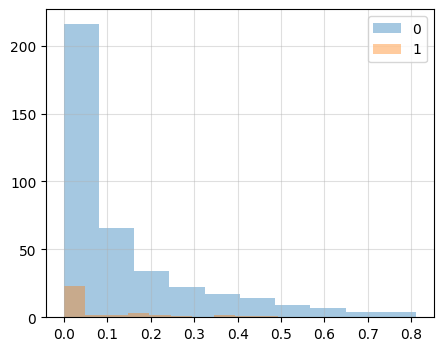

In [42]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.grid(alpha=0.4)
for l in np.unique(labels):
    idx = np.where(labels == l)[0]
    ax.hist(scores[idx], alpha=0.4, label=l)
ax.legend()
plt.show()

In [43]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(labels, scores)
average_precision

0.07009154131252236

1. Try using sum of all tokens that coresspond to `Yes`/`No`.
2. Try generating actual text `Yes`/`No` and compute the binary accuracy instead of AP.

In [11]:
results

[{'video_path': 'u35WIs62R2M.1.4.mp4',
  'question': 'Does the camera move downward (not tilting down) with respect to the initial frame?',
  'ground_truth_label': 'Yes',
  'score': 4.934132107337064e-07,
  'error': None}]

In [25]:
encoder.processor.tokenizer.encode('No'), \
encoder.processor.tokenizer.encode('Yes')

([1, 1939], [1, 3869])

In [30]:
yes_token_id = encoder.processor.tokenizer.encode('Yes')[-1]
no_token_id = encoder.processor.tokenizer.encode('No')[-1]
yes_token_id, no_token_id

(3869, 1939)

In [26]:
torch.nn.functional.softmax(scores[0][[yes_token_id, no_token_id]], dim=-1)

tensor([0.1925, 0.8075], device='cuda:0')

In [28]:
answer

'Yes'

In [10]:
scores[0]

tensor([-5.2812, -6.4688,  1.9531,  ..., -7.6875, -3.9688, -2.9531],
       device='cuda:0')

In [85]:
scores[0][yes_token_id, no_token_id], scores[0][no_token_id]

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [82]:
yes_token_id = encoder.processor.tokenizer.encode('Yes')[-1]
no_token_id = encoder.processor.tokenizer.encode('No')[-1]
torch.nn.functional.softmax(scores[0, [yes_token_id, no_token_id]], dim=-1)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [79]:
scores.shape

torch.Size([1, 32064])

In [78]:
results

[{'video_path': 'u35WIs62R2M.1.4.mp4',
  'question': 'Does the camera move downward (not tilting down) with respect to the initial frame?',
  'ground_truth_label': 'Yes',
  'score': 4.934132107337064e-07,
  'error': None}]

In [59]:
scores.shape, probs.shape

(torch.Size([1, 32064]), torch.Size([1, 32064]))

In [67]:
probs[0, 3869], probs[0, 6213]

(tensor(4.9341e-07, device='cuda:0'), tensor(3.1435e-08, device='cuda:0'))

In [ ]:
plt.plot

In [63]:
answer

'Yes'

In [64]:
encoder.processor.tokenizer.encode('Yes'), \
encoder.processor.tokenizer.encode('None')

([1, 3869], [1, 6213])

In [61]:
yes_token_id = encoder.processor.tokenizer.encode(answer)[0]
yes_token_id

1

In [55]:
len(pixel_values)

1

In [52]:
question, answer, lm_prob

('Does the camera move downward (not tilting down) with respect to the initial frame? Please only answer Yes or No.',
 'Yes',
 6.944944619391435e-10)

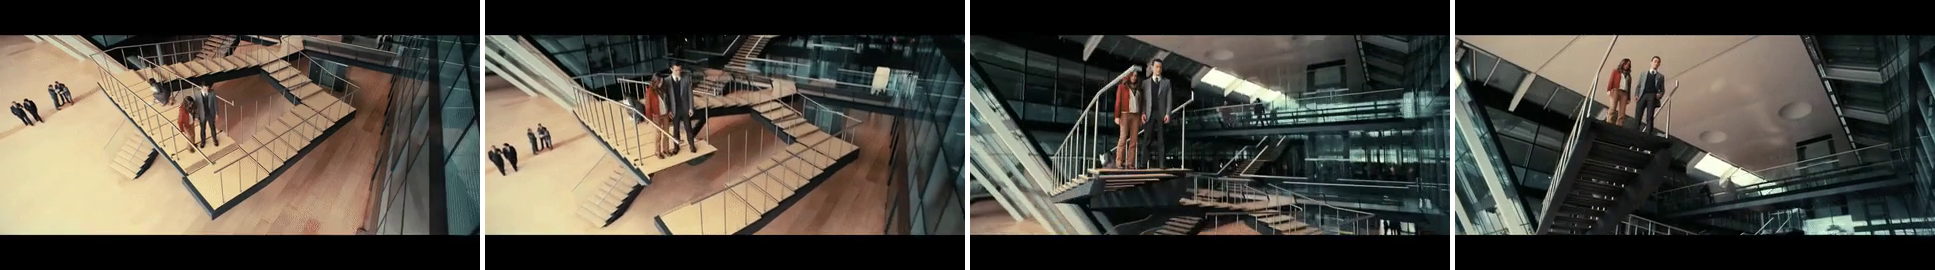

In [45]:
su.visualize.concat_images_with_border(batched_frames[0][::4])

In [18]:
# Process one sample at a time
video_base_path = f"{data_dir}/videos"
for item in tqdm(data, desc="Computing VQA scores"):
    full_video_path = f"{data_dir}/{item['path']}"
    assert os.path.exists(full_video_path)

    question = item['question']
    label = item['label']
    
    # Create result entry with metadata
    result_entry = {
        "video_path": full_video_path,
        "question": question,
        "ground_truth_label": label,
        "score": None,
        "error": None,
    }
    

    break

Computing VQA scores:   0%|                                                                                                | 0/1071 [00:00<?, ?it/s]


KeyError: 'question'

In [19]:
item

{'Video': 'https://huggingface.co/datasets/syCen/CameraBench/resolve/main/videos_gif/-2uIa-XMJC0.5.3.gif',
 'labels': ['minimal-shaking', 'complex-motion', 'regular-speed', 'tilt-down'],
 'caption': 'The camera smoothly trucks slightly to the left, then quickly tilts downward before moving backward to follow the skateboarder, maintaining minimal shaking throughout.',
 'path': 'videos/-2uIa-XMJC0.5.3.mp4'}

In [13]:
item

{'Video': 'https://huggingface.co/datasets/syCen/CameraBench/resolve/main/videos_gif/-2uIa-XMJC0.5.3.gif',
 'labels': ['minimal-shaking', 'complex-motion', 'regular-speed', 'tilt-down'],
 'caption': 'The camera smoothly trucks slightly to the left, then quickly tilts downward before moving backward to follow the skateboarder, maintaining minimal shaking throughout.',
 'path': 'videos/-2uIa-XMJC0.5.3.mp4'}

In [ ]:
def generate_vqa_scores(
    data,
    model_name,
    video_base_path,
    checkpoint_name=None,
    question_template="{} Please only answer Yes or No.",
    answer_template="Yes",
):
    """Generate VQA scores for all samples using the specified model"""
    print(f"Initializing VQAScore model: {model_name}")
    
    if checkpoint_name:
        vqa_scorer = t2v_metrics.VQAScore(model=model_name, checkpoint=checkpoint_name)
    else:
        vqa_scorer = t2v_metrics.VQAScore(model=model_name)
    
    results = []
    
    # Process one sample at a time
    for item in tqdm(data, desc="Computing VQA scores"):
        video_path = item['image']  # Note: using 'image' key for video path
        question = item['question']
        label = item['label']
        
        # Create result entry with metadata
        result_entry = {
            "video_path": video_path,
            "question": question,
            "ground_truth_label": label,
            "method": f"{model_name}" + (f"_{checkpoint_name}" if checkpoint_name else ""),
            "score": None,
            "error": None
        }
        
        # Construct full video path
        full_video_path = os.path.join(video_base_path, video_path)
        
        # Check if video file exists
        if not os.path.exists(full_video_path):
            print(f"Warning: Video not found: {full_video_path}")
            result_entry["error"] = f"Video file not found: {full_video_path}"
            result_entry["score"] = 0.0  # Default score for missing files
            results.append(result_entry)
            continue
        
        try:
            # Compute VQA score for single sample
            score_kwargs = {
                "question_template": question_template,
                "answer_template": answer_template
            }
            
            score = vqa_scorer(images=[full_video_path], texts=[question], **score_kwargs)
            result_entry["score"] = float(score[0].detach().cpu().item())  # Convert tensor to Python float
            
        except Exception as e:
            print(f"Error processing {full_video_path}: {e}")
            result_entry["error"] = str(e)
            result_entry["score"] = 0.0  # Default score for failed samples
        
        results.append(result_entry)
    
    return results